Upload data to sqlite tables.

In [1]:
import pandas as pd
import numpy as np
from IPython import display as dis
import scipy.io.wavfile as wav
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell
from scipy import signal 
from librosa import core
from matplotlib import pyplot as plt
import time

%matplotlib inline

In [2]:
dis.Audio("dataset/wav/Ses01F_impro01/Ses01F_impro01_F011.wav")

In [55]:
(sig,rate) = core.load("dataset/wav/Ses01F_impro01/Ses01F_impro01_F011.wav", sr = 8000)
print(sig, rate, len(sig))

[-0.01335607  0.00451396 -0.00446299 ..., -0.0015959  -0.0017785
 -0.00236306] 8000 78480


In [56]:
time_step = len(sig)
hidden_layers = 1
batch_size = 1
feature_count = 1
latent_dim = 61 

In [57]:
dis.Audio(data = sig, rate = rate)

In [53]:
#["batch_size", "steps", "step_size", "feature_count"]
[batch_size, time_step, feature_count ]

[1, 78480, 1]

In [59]:
sigs = []
sig = np.reshape(sig, (-1,1)) #clipping out the remaining signal that cannot be fully accomodated in the batch

sigs.append(sig)
sigs = np.asarray(sigs)
print(sigs.shape)

(1, 78480, 1)


In [60]:
dis.Audio(data = sigs[0].ravel(), rate = rate)

In [61]:
class Data(object):
    x = sigs
    
class network(object):
    
    def __init__(self):
        pass
            
    def build_layers(self):
        
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        global time_step 
        global batch_size 
        global hidden_layers
        global step_size
        global latent_dim
        
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float32", shape=[batch_size, time_step, feature_count], name='x')
            self.y_ = tf.placeholder("float32", shape=[batch_size, time_step, feature_count], name='y')
            
            self.keep_prob = tf.placeholder("float", name='kp')
            self.lr = tf.placeholder("float", name='lr')
            
        with tf.variable_scope("encoder"):
            enc_lstm = tf.contrib.rnn.LSTMCell(latent_dim)
            
            self.state = enc_lstm.zero_state(batch_size, "float")
            print("State:",self.state)
            
            print("Audio Input:", self.x)
            self.enc_output, self.state = tf.nn.dynamic_rnn(enc_lstm, self.x, initial_state = self.state)
            print("Encoder Output:",self.enc_output)

        with tf.variable_scope("decoder"):
            dec_lstm = tf.contrib.rnn.LSTMCell(latent_dim)
            self.dec_output, self.state = tf.nn.dynamic_rnn(dec_lstm, self.enc_output, initial_state = self.state)
            self.output = tf.layers.dense(self.dec_output, units = 1)
            print("Decoder Output:",self.dec_output)
            
        print("Final Output:", self.output)

            
        

In [62]:
import collections

y_pred_list = []
final_state = None
class Train:    
    
    def train(net, epochs, lr, x):
        global final_state
        
        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(1, epochs+1):
                print("Step {} ".format(epoch))
                x_train = y_train = x

                Data.state, Data.enc_output = sess.run([net.state, net.enc_output], #net.summary_op
                                          feed_dict={net.x: x_train, 
                                                     net.y_: y_train,
                                                     net.keep_prob:1,
                                                     net.lr:lr})


In [63]:
import itertools

class Hyperparameters:
    def start_training():
        
        epochs = 1
        lr = 1e-5
        n = network()
        n.build_layers()
        #Train.train(n, epochs, lr, Data.x)
            

In [64]:
Hyperparameters.start_training()

State: LSTMStateTuple(c=<tf.Tensor 'encoder/LSTMCellZeroState/zeros:0' shape=(1, 61) dtype=float32>, h=<tf.Tensor 'encoder/LSTMCellZeroState/zeros_1:0' shape=(1, 61) dtype=float32>)
Audio Input: Tensor("Input/x:0", shape=(1, 78480, 1), dtype=float32)
Encoder Output: Tensor("encoder/rnn/transpose:0", shape=(1, 78480, 61), dtype=float32)
Decoder Output: Tensor("decoder/rnn/transpose:0", shape=(1, 78480, 61), dtype=float32)
Final Output: Tensor("decoder/dense/BiasAdd:0", shape=(1, 78480, 1), dtype=float32)


In [218]:
Data.enc_output = np.array(Data.enc_output)
Data.enc_output.shape

(61,)

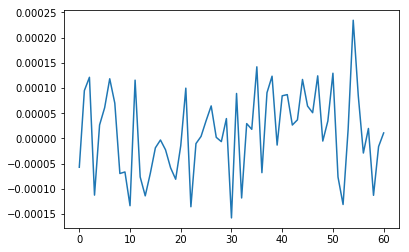

In [213]:
plt.plot(Data.enc_output[0])

In [155]:
Data.state

LSTMStateTuple(c=array([], shape=(1, 0), dtype=float32), h=array([], shape=(1, 0), dtype=float32))

In [ ]:
dis.Audio(data = y, rate = rate)

In [ ]:
final_state